In [ ]:
library(Seurat)
library(SeuratWrappers)
library(monocle3)

### Seurat Object

In [4]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20200913_n27632/seurat.rds")
rna$tech = "rna"

### Config

In [8]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#F4D5CD,Intermediate,12
2,2,#78A824,Pre-iPSC,15
3,3,#F01D35,Fibroblast-like,5
4,4,#E85F6D,Fibroblast-like,3
5,5,#B03743,Fibroblast,1
6,6,#7C2730,Fibroblast,2
7,7,#CF175A,Fibroblast-like,4
8,8,#CCCCCC,Doublets,17
9,9,#F7A6C2,Keratinocyte-like,6


### ATAC-RNA Label Transfer

In [9]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n27632/atac.20200520_n68916.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,5,1
AAACCCAAGTGCCAGA-1,D0,5,1
AAACCCACACCATTCC-1,D0,6,2
AAACCCACACGCGTCA-1,D0,5,1
AAACCCAGTCCATAGT-1,D0,6,2
AAACCCAGTTATTCTC-1,D0,6,2


## Inference

In [10]:
cds <- as.cell_data_set(rna)

Warning message:
“Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object”


In [11]:
cds <- cluster_cells(cds)

In [12]:
cds.sub <- subset(as.Seurat(cds), monocle3_partitions == 1)
cds <- as.cell_data_set(cds.sub)
cds <- learn_graph(cds)

Using existing Monocle 3 cluster membership and partitions



  |======================================================================| 100%


In [14]:
?learn_graph

learn_graph {monocle3},R Documentation
cds,the cell_data_set upon which to perform this operation
use_partition,"logical parameter that determines whether to use partitions calculated during cluster_cells and therefore to learn disjoint graph in each partition. When use_partition = FALSE, a single graph is learned across all partitions. Default is TRUE."
close_loop,logical parameter that determines whether or not to perform an additional run of loop closing after estimating the principal graphs to identify potential loop structure in the data space. Default is TRUE.
learn_graph_control,NULL or a list of control parameters to be passed to the reversed graph embedding function. Default is NULL. A list of potential control parameters is provided in details.
verbose,Whether to emit verbose output during graph learning.


Warning message:
“`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


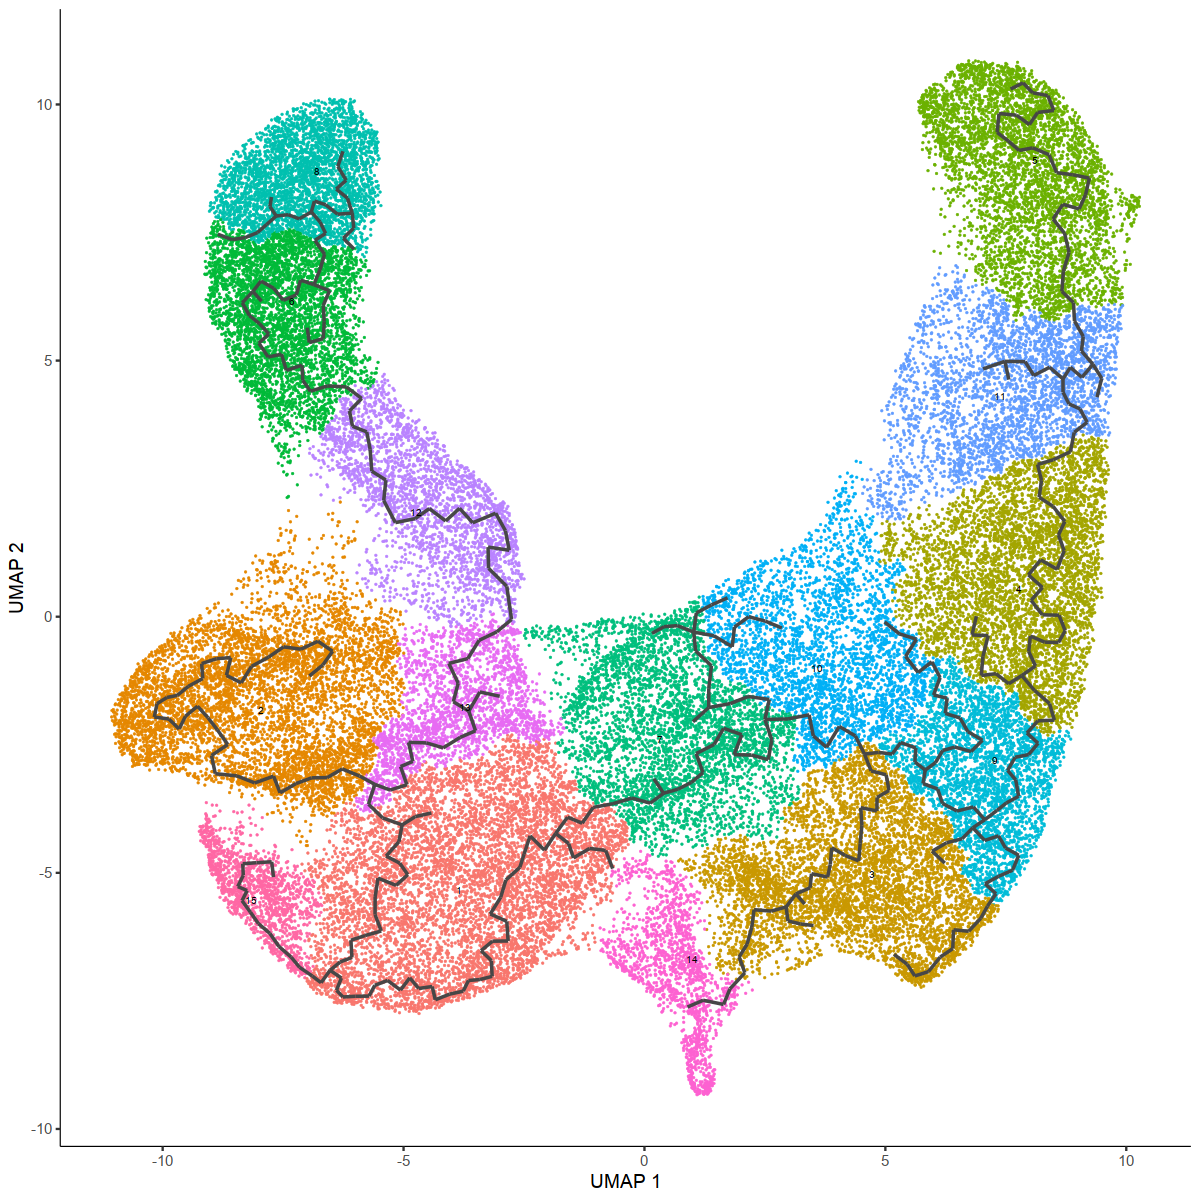

In [13]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_cells(cds, label_groups_by_cluster = FALSE, label_leaves = FALSE, label_branch_points = FALSE)